In [ ]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def community_detection(nodes,edges,population=300,generation=30,r=1.5):
    
    graph=nx.Graph()
    graph.add_nodes_from(nodes)
    graph.add_edges_from(edges)
    Adj = nx.adjacency_matrix(graph)
    nodes_length = len(graph.nodes())

    d = {"chrom":[generate_chrom(nodes_length,Adj) for n in range(population)]}
    dframe = pd.DataFrame(data= d)
    dframe["subsets"] = dframe["chrom"].apply(find_subsets)
    dframe["community_score"]=dframe.apply(lambda x: community_score(x["chrom"],x["subsets"],r,Adj),axis=1)
    
    gen = 0
    population_count = population
    while gen < generation:
        for i in range(int(np.floor(population/10))):
            p1 = 0
            p2 = 0
            elites = dframe.sort_values("community_score",ascending=True)[int(np.floor(population/10)):]
            p1 = roulette_selection(elites)
            p2 = roulette_selection(elites)
            child=uniform_crossover(dframe["chrom"][p1],dframe["chrom"][p2],0.8)
            if len(child)==0:
                continue
            child=mutation(child,Adj,0.2)
            child_subsets = find_subsets(child)
            child_cs = community_score(child,child_subsets,r,Adj)
            dframe.loc[population_count]=[child,child_subsets,child_cs]
            population_count += 1
        dfsorted = dframe.sort_values("community_score",ascending=False)
        to_drop = dfsorted.index[population:]
        dframe.drop(to_drop,inplace=True)
        gen +=1        
    sorted_df = dframe.sort_values("community_score",ascending=False).index[0]
    print(dframe.sort_values("community_score",ascending=False).head(5)["community_score"])
    nodes_subsets = dframe["subsets"][sorted_df]
    nodes_list = list(graph.nodes())
    result = []
    for subs in nodes_subsets:
        subset = []
        for n in subs:
            subset.append(nodes_list[n])
        result.append(subset)
    return result

def generate_chrom(nodes_length,Adj):
    chrom = np.array([],dtype=int)
    for x in range(nodes_length):
        rand = np.random.randint(0,nodes_length)
        while Adj[x,rand] != 1:
            rand = np.random.randint(0,nodes_length)
        chrom = np.append(chrom,rand)
    return chrom

def merge_subsets(sub):
    arr =[]
    to_skip=[]
    for s in range(len(sub)):
        if sub[s] not in to_skip:
            new = sub[s]
            for x in sub:
                if sub[s] & x:
                    new = new | x
                    to_skip.append(x)
            arr.append(new)
    return arr

def find_subsets(chrom):
    sub = [{x,chrom[x]} for x in range(len(chrom))]
    result=sub
    i=0
    while i<len(result):
        candidate = merge_subsets(result)
        if candidate != result:
            result = candidate
        else:
            break
        result=candidate
        i+=1
    return result

def community_score(chrom,subsets,r,Adj):
    matrix = Adj.toarray()
    CS=0
    for s in subsets:
        submatrix = np.zeros((len(chrom),len(chrom)),dtype=int)
        for i in s:
            for j in s:
                submatrix[i][j]=matrix[i][j]
        M=0
        v=0
        for row in list(s):
            row_mean = np.sum(submatrix[row])/len(s)
            v+=np.sum(submatrix[row])
            M+=(row_mean**r)/len(s)
        CS+=M*v
    return CS

def roulette_selection(df_elites):
    prob = np.random.random_sample()
    sum_cs=np.sum(df_elites["community_score"])
    x=0
    selected = 0
    for i in df_elites.index:
        x += df_elites["community_score"][i]
        X=x/sum_cs
        if prob < X:
            chosen=i
            break
    return chosen

def uniform_crossover(parent_1,parent_2,crossover_rate):
    if np.random.random_sample() < crossover_rate:
        length = len(parent_1)
        mask = np.random.randint(2, size=length)
        child = np.zeros(length,dtype=int)
        for i in range(len(mask)):
            if mask[i] == 1:
                child[i]=parent_1[i]
            else:
                child[i]=parent_2[i]
        return child
    else:
        return np.array([])

def mutation(chrom,Adj,mutation_rate):
    if np.random.random_sample() < mutation_rate:
        chrom = chrom
        neighbor = []
        while len(neighbor) < 2:
            mutant = np.random.randint(1,len(chrom))
            row = Adj[mutant].toarray()[0]
            neighbor = [i for i in range(len(row)) if row[i]==1]
            if len(neighbor) > 1:
                neighbor.remove(chrom[mutant])
                to_change=int(np.floor(np.random.random_sample()*(len(neighbor))))
                chrom[mutant]=neighbor[to_change]
                neighbor.append(chrom[mutant])
    return chrom


In [ ]:
def draw_communities(G,communities, node_size=30, alpha=1, k=None, randomized=False):


    community_map = {}
    i=0
    for c in comm :
      for n in c :
        community_map[n] = i
      i+=1

    cmap = plt.get_cmap("jet")
    pos = nx.spring_layout(G)
    indexed = [community_map.get(node) for node in G]
    plt.axis("off")

    nx.draw_networkx_nodes(G, pos=pos, cmap=cmap, node_color=indexed, node_size=node_size, alpha=alpha)
    nx.draw_networkx_edges(G, pos=pos, alpha=0.2)

0     16.827432
25    16.827432
50    16.827432
48    16.827432
41    16.827432
Name: community_score, dtype: float64


[[0, 1, 2, 3], [4, 5, 6], [7, 8, 9, 10]]

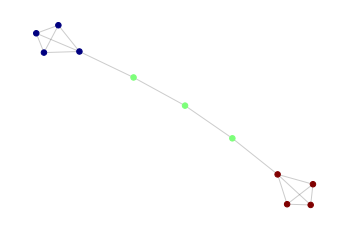

In [ ]:
nodes = [0,1,2,3,4,5,6,7,8,9,10]
edges = [(0,1),(0,4),(1,2),(2,3),(1,3),(3,0),(0,2),(4,5),(5,6),(6,7),(10,8),(10,9),(8,9),(8,7),(9,7),(7,10)]
graph=nx.Graph()
graph.add_nodes_from(nodes)
graph.add_edges_from(edges)

comm = community_detection(nodes,edges,generation=10,population=30)
draw_communities(graph,comm)
comm

4590    376.664917
5040    365.865060
4106    362.690337
4693    359.496807
4192    357.626492
Name: community_score, dtype: float64


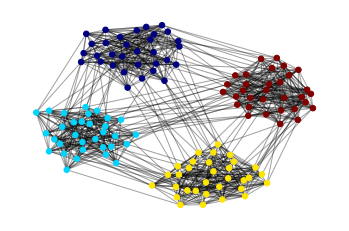

In [ ]:
graph = nx.MultiGraph()
nx.read_edgelist('network.dat', create_using=graph, nodetype=int, data=(('weight', float),))
nodes = graph.nodes()
edges = graph.edges()

comm = community_detection(nodes,edges,generation=80,population=700,r=2)
draw_communities(graph,comm)